In [1]:
# Imports
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
from scipy.stats import expon, uniform
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from pprint import pprint
import sys
import os
import seaborn as sns
import statistics
import random
import collections
import tensorflow_datasets as tfds

from tensorflow_probability.python.mcmc.transformed_kernel import (
    make_transform_fn, make_transformed_log_prob)

tfb = tfp.bijectors
tfd = tfp.distributions
dtype = tf.float32
tfde = tfp.experimental.distributions


# Control versions of TF and TFP

In [255]:
def plot(x):
    fig = plt.figure(figsize=(6, 2))
    sns.distplot(x, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 1}, color = 'c')
    plt.axvline(x = statistics.median(x))
    print(statistics.median(x))
    plt.xlim(0,3)

In [2]:
tf.__version__

'2.6.0-dev20210616'

In [3]:
tfp.__version__

'0.13.0'

# Example model: Normal distirbution

In [28]:
# Example model 

mu = 12
sigma = 2.2
data = np.random.normal(mu, sigma, size=1000)

# Defining the model
model = tfd.JointDistributionSequential([
    # sigma_prior
    tfd.Exponential(1, name='sigma'),

    # mu_prior
    tfd.Normal(loc=0, scale=10, name='mu'),

    # likelihood
    lambda mu, sigma: tfd.Normal(loc=mu, scale=sigma)
])

#simple normal example
print(model.resolve_graph())
joint_log_prob = lambda *x: model.log_prob(x + (data,))
model.sample()

(('sigma', ()), ('mu', ()), ('x', ('mu', 'sigma')))


[<tf.Tensor: shape=(), dtype=float32, numpy=2.1403925>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-6.5772223>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-7.2311325>]

# Real model: Simplified ASE model 

In [177]:
#### Simulated data from STANINPUTS
depth = 5
theta = 2
data = []
with open("JABS/STANINPUTS/data_N1000_H1_D{}_T2_F0.txt".format(depth),"rt") as IN:
        for line in IN:
            fields=line.rstrip().split()
            fields = [float(i) for i in fields]
            #fields = fields[2:3]
            data.append(fields[2:3])
data = sum(data,[])

#### Simulated data from np

data = np.random.binomial(depth*100,theta/(1+theta), 1000)


#### Defining the model
sigma = 0.5
model = tfd.JointDistributionSequential([
    # log2_theta prior
    tfd.Normal(loc=0, scale=sigma, name='log2_theta'),

    # likelihood
    lambda log2_theta: tfd.Binomial(depth*100,probs = (pow(2,log2_theta)/(1+ pow(2,log2_theta)) )) 
])


#simple normal example
print(model.resolve_graph())
joint_log_prob = lambda *x: model.log_prob(x + (data,))
model.sample()

(('log2_theta', ()), ('x', ('log2_theta',)))


[<tf.Tensor: shape=(), dtype=float32, numpy=0.069106385>,
 <tf.Tensor: shape=(), dtype=float32, numpy=241.0>]

# Multilevel Example
https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb#scrollTo=-bPcpgMsIykz


# Real model: BIRD model 

In [ ]:
# BIRD STAN code
data {
   int<lower=1> N_VARIANTS;             // number of variants in the model
   real<lower=0,upper=1> v[N_VARIANTS]; // alt allele freq in VCF file
   int<lower=1> N_DNA;                  // number of DNA replicates
   int<lower=0> a[N_VARIANTS,N_DNA];   // DNA alt read counts
   int<lower=0> b[N_VARIANTS,N_DNA];   // DNA ref read counts
   int<lower=1> N_RNA;                  // number of RNA replicates
   int<lower=0> k[N_VARIANTS,N_RNA];   // RNA alt read counts
   int<lower=0> m[N_VARIANTS,N_RNA];   // RNA ref read counts
}

parameters {
   real<lower=0,upper=1> p[N_VARIANTS]; // alt allele freq in DNA
   real<lower=0,upper=1> qi[N_VARIANTS,N_RNA]; // alt freqs in RNA
   real<lower=0> theta[N_VARIANTS];
   real<lower=2> c1; // concentration parameter of beta prior for qi
   real<lower=2> c2; // concentration parameter of beta prior for p
   real<lower=0> s; // std.dev. parameter of lognormal prior for theta
}

transformed parameters { // ORDER MATTERS!
   real<lower=0,upper=1> q[N_VARIANTS]; // alt allele freq in RNA
   for(j in 1:N_VARIANTS)
      q[j]=theta[j]*p[j]/(1.0-p[j]+theta[j]*p[j]);
}

model {
   // Parameters
   c1 ~ gamma(1.1, 0.005);
   c2 ~ gamma(1.1, 0.005);
   s ~ gammaModeSD(1,1);

   for(j in 1:N_VARIANTS) {
      p[j] ~ betaModeConc(v[j],c2);
      #
      log(theta[j])/s ~ normal(0,1); // theta~lognormal(0,s)
      target+=-log(theta[j])-log(s); // Jacobian
      for(i in 1:N_RNA)
         qi[j,i] ~ betaModeConc(q[j],c1);
      for(i in 1:N_DNA)
         a[j,i] ~ binomial(a[j,i]+b[j,i],p[j]);
      for(i in 1:N_RNA)
         k[j,i] ~ binomial(k[j,i]+m[j,i],qi[j,i]);
   }
}


In [346]:
# BIRD Function 
def GammaModeSD(mode, sd, name = None):
    r=(mode+np.sqrt(mode**2+4*(sd**2)))/(2*(sd**2))
    s=1 + (mode*r)
    return tfd.Gamma(concentration= tf.cast(r,tf.float32), rate = tf.cast(s,tf.float32), name= name)

def BetaModeConc(mode,c, name = None):
    c1 = mode*(c-2)+1
    c2 = (1-mode)*(c-1)+1
    return tfd.Beta(concentration1 = tf.cast(c1,tf.float32), concentration0=tf.cast(c2,tf.float32), name = name)


In [358]:
N_V = 10
N_DNA  =1
N_RNA = 10
V = 0.1
D_DNA = 300
D_RNA = 30
DNA = [[150]*N_DNA]*N_V
RNA = [[15]*N_RNA]*N_V


@tfd.JointDistributionCoroutineAutoBatched
def model():
    ## c1 prior 
    c1 = yield tfd.Gamma(concentration = 1.1, rate = 0.005, name = "c1")
    ## c2 prior
    c2 = yield tfd.Gamma(concentration = 1.1, rate = 0.005, name = "c2")
    ## s prior 
    s = yield GammaModeSD(1,1, name = "s")
    ## theta prior 
    theta = yield tfd.Sample(tfd.LogNormal(0,s,name = "theta"), sample_shape=[N_V], name = "theta")
    ## p prior
    p = yield tfd.Sample(BetaModeConc(0.1,c1,name = "p"), sample_shape= [N_V], name = "p")
    ## tfp bug, need to cast tensor to float32
    #theta = tf.cast(theta, tf.float32)
    #p = tf.cast(p, tf.float32)
    ## q formula
    q = (theta*p)/(1-p+theta*p)
    ## qi prior 
    qi = yield tfd.Sample(BetaModeConc(q, c2, name = "qi"),sample_shape=[N_RNA], name = "qi")
    ## qi likelihood 
    yield tfd.Binomial(tf.cast(D_RNA,tf.float32),qi, name = "k")
    # p likelihood
    yield tfd.Binomial(tf.cast(D_DNA,tf.float32),p, name = "a")    


target_model = model.experimental_pin(a = DNA, k = RNA)

model.sample()



StructTuple(
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=208.56717>,
  c2=<tf.Tensor: shape=(), dtype=float32, numpy=119.7016>,
  s=<tf.Tensor: shape=(), dtype=float32, numpy=1.0168474>,
  theta=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([3.0010018 , 0.15060464, 0.8979827 , 4.072646  , 2.126497  ,
           1.1117243 , 0.20129718, 1.3587592 , 1.0721883 , 0.4174209 ],
          dtype=float32)>,
  p=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([0.10762128, 0.09902164, 0.09412014, 0.12293765, 0.09795275,
           0.09797671, 0.08842909, 0.11935028, 0.1315391 , 0.08076626],
          dtype=float32)>,
  qi=<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
    array([[0.23839992, 0.2900599 , 0.3372831 , 0.25857127, 0.23782828,
            0.25681162, 0.28601247, 0.24657485, 0.30077696, 0.28241098],
           [0.02376759, 0.06525993, 0.04023969, 0.01561907, 0.01232368,
            0.00938773, 0.01473299, 0.03366718, 0.04613873, 0.02386975],
           [0.0811

In [406]:
## single site BIRD
N_V = 1
N_DNA  =1
N_RNA = 10
V = 0.1
D_DNA = 100
D_RNA = 10
DNA = [150]*N_DNA
RNA = [15]*N_RNA

@tfd.JointDistributionCoroutineAutoBatched
def model():
    ## c1 prior 
    c1 = yield tfd.Gamma(concentration = 1.1, rate = 0.005, name = "c1")
    ## c2 prior
    c2 = yield tfd.Gamma(concentration = 1.1, rate = 0.005, name = "c2")
    ## s prior 
    s = yield GammaModeSD(1,1, name = "s")
    ## theta prior 
    theta = yield tfd.LogNormal(0,s, name = "theta")
    ## p prior
    p = yield BetaModeConc(0.1,c1, name = "p")
    ## tfp bug, need to cast tensor to float32
    #theta = tf.cast(theta, tf.float32)
    #p = tf.cast(p, tf.float32)
    ## q formula
    q = (theta*p)/(1-p+theta*p)
    ## qi prior 
    qi = yield tfd.Sample(BetaModeConc(q, c2, name = "qi"),sample_shape=[N_RNA], name = "qi")
    ## qi likelihood 
    yield tfd.Binomial(tf.cast(D_RNA,tf.float32),qi, name = "k")
    # p likelihood
    yield tfd.Binomial(tf.cast(D_DNA,tf.float32),p, name = "a")    


target_model = model.experimental_pin(a = DNA, k = RNA)






In [407]:
# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying standard Normal distribution, and the dimensions of the blocks in
# the blockwise matrix transformation.
event_shape = target_model.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this at the end to constrain Multivariate Normal
# samples to the prior's support.
event_space_bijector = target_model.experimental_default_event_space_bijector()



In [408]:
# A block-diagonal linear operator, in which each block is a diagonal operator,
# transforms the standard Normal base distribution to produce a mean-field
# surrogate posterior.
operators = (tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag)
block_diag_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
mean_field_scale = tfb.ScaleMatvecLinearOperatorBlock(block_diag_linop)

mean_field_loc = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))

mean_field_surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector, # reshape the vector-valued components to match the shapes of the posterior components
         mean_field_loc,   # allow for nonzero mean
         mean_field_scale  # apply the block matrix transformation to the standard Normal distribution
         ]))


optimizer=tf.optimizers.Adam(learning_rate=1e-2)
@tf.function(jit_compile=True)
def fit_vi():
    return tfp.vi.fit_surrogate_posterior(
        target_model.unnormalized_log_prob,
        mean_field_surrogate_posterior,
        optimizer=optimizer,
        num_steps=5000,
        sample_size=1)
mean_field_loss = fit_vi()

mean_field_samples = mean_field_surrogate_posterior.sample(1000)
mean_field_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*mean_field_samples)

    - mean_field_surrogate_posterior.log_prob(mean_field_samples))
print('Mean-field surrogate posterior ELBO: {}'.format(mean_field_final_elbo))



/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/vectorization_util.py:91: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionCoroutineAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  warnings.warn(
/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/vectorization_util.py:91: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionCoroutineAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovect

Mean-field surrogate posterior ELBO: -inf


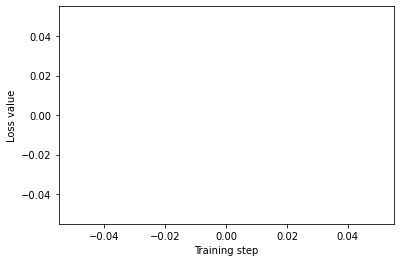

In [409]:
plt.plot(mean_field_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

1.0051374435424805


/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


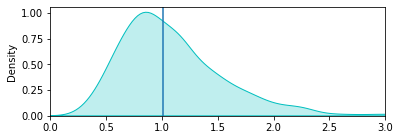

In [410]:
plot(np.array(mean_field_samples[3]))

In [364]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)])

# Apply an IAF to the base distribution.
num_iafs = 6
iaf_bijectors = [
    tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[256, 256], activation='relu')))
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`,
# `unflatten_bijector`, and `reshape_bijector` are the same as in the
# multivariate Normal surrogate posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the prior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the prior components
         split] +  # Split the samples into components of the same size as the prior components
         iaf_bijectors  # Apply a flow model to the Tensor-valued standard Normal distribution
         ))

ValueError: Differences between `event_ndims` and `min_event_ndims must be equal for all elements of the structured input. Saw event_ndims=[1, 1, 1, 2, 2, 2], min_event_ndims=[1, 1, 1, 1, 1, 1].

In [365]:
optimizer=tf.optimizers.Adam(learning_rate=1e-2)
@tf.function(jit_compile=True)
def fit_vi():
  return tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    iaf_surrogate_posterior,
    optimizer=optimizer,
    num_steps=5000,
    sample_size=1
    )
iaf_loss = fit_vi()

iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*iaf_samples)

    - iaf_surrogate_posterior.log_prob(iaf_samples))
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))

plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')

/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/vectorization_util.py:91: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionCoroutineAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  warnings.warn(
/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/vectorization_util.py:91: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionCoroutineAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovect

ValueError: Incompatible shapes for broadcasting: (1000,) and (10,)

In [329]:
iaf_samples

StructTuple(
  c1=<tf.Tensor: shape=(1000,), dtype=float32, numpy=
    array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
           nan, nan, 

In [74]:
N = 1


# Build Mean Field ADVI
def build_mf_advi():
    parameters = list(model.sample(1))
    parameters.pop()
    dists = []
    for i, parameter in enumerate(parameters):
        shape = parameter[0].shape
        loc = tf.Variable(
            tf.random.normal(shape, dtype=dtype),
            name=f'meanfield_{i}_loc',
            dtype=dtype
        )
        scale = tfp.util.TransformedVariable(
            tf.fill(shape, value=tf.constant(0.02, dtype=dtype)),
            tfb.Softplus(), # For positive values of scale
            name=f'meanfield_{i}_scale'
        )

        approx_parameter = tfd.Normal(loc=loc, scale=scale)
        dists.append(approx_parameter)
    return tfd.JointDistributionSequential(dists)

meanfield_advi = build_mf_advi()


unconstraining_bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Identity(),
    tfb.Exp()
]

posterior = make_transformed_log_prob(
    target_log_prob_fn,
    unconstraining_bijectors,
    direction='forward',
    enable_bijector_caching=False
)

opt = tf.optimizers.Adam(learning_rate=.1)

@tf.function(autograph=False)
def run_approximation():
    elbo_loss = tfp.vi.fit_surrogate_posterior(
        posterior,
        surrogate_posterior=meanfield_advi,
        optimizer=opt,
        sample_size=1000,
        num_steps=10000)
    return elbo_loss

elbo_loss = run_approximation()



ValueError: Joint distribution expected values for 8 components ['c1', 'c2', 's', 'theta', 'p', 'qi', 'k', 'a']; saw 9 (from args (<tf.Tensor 'monte_carlo_variational_loss/expectation/exp/forward/Exp:0' shape=(1000,) dtype=float32>, <tf.Tensor 'monte_carlo_variational_loss/expectation/Identity_1:0' shape=(1000,) dtype=float32>, <tf.Tensor 'monte_carlo_variational_loss/expectation/Identity_2:0' shape=(1000,) dtype=float32>, <tf.Tensor 'monte_carlo_variational_loss/expectation/Identity_3:0' shape=(1000,) dtype=float32>, <tf.Tensor 'monte_carlo_variational_loss/expectation/Identity_4:0' shape=(1000,) dtype=float32>, <tf.Tensor 'monte_carlo_variational_loss/expectation/Identity_5:0' shape=(1000, 10) dtype=float32>, <tf.Tensor 'monte_carlo_variational_loss/expectation/exp_1/forward/Exp:0' shape=(1000, 10) dtype=float32>) and kwargs {'a': [150], 'k': [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]}).

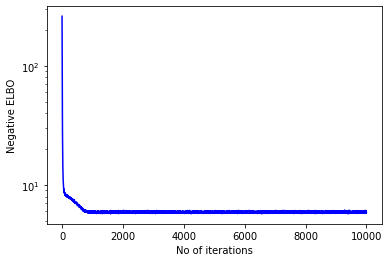

In [34]:
#### Show ELBO curve through iteration
# decrease the num_step according to the maximized ELBO plot
plt.plot(elbo_loss, color='blue')
plt.yscale("log")
plt.xlabel("No of iterations")
plt.ylabel("Negative ELBO")
plt.show()

In [35]:
graph_info = model.resolve_graph()
approx_param = dict()
free_param = meanfield_advi.trainable_variables
for i, (rvname, param) in enumerate(graph_info[:-1]):
    approx_param[rvname] = {"mu": free_param[i*2].numpy(),
                            "sd": free_param[i*2+1].numpy()}
    
    
#### approximate distribution parameter
print(approx_param)

{'sigma': {'mu': 0.80642253, 'sd': -0.7141728}, 'mu': {'mu': 11.482767, 'sd': 1.7579931}}


In [10]:
#### Recover theta & p
theta = pow(2,np.exp(approx_param['log2_theta']['mu']))
print(theta)

KeyError: 'log2_theta'

# VI Example
https://www.tensorflow.org/probability/examples/Variational_Inference_and_Joint_Distributions

In [4]:
# Load the Radon dataset from `tensorflow_datasets` and filter to data from
# Minnesota.
dataset = tfds.as_numpy(
    tfds.load('radon', split='train').filter(
        lambda x: x['features']['state'] == 'MN').batch(10**9))

# Dependent variable: Radon measurements by house.
dataset = next(iter(dataset))
radon_measurement = dataset['activity'].astype(np.float32)
radon_measurement[radon_measurement <= 0.] = 0.1
log_radon = np.log(radon_measurement)

# Measured uranium concentrations in surrounding soil.
uranium_measurement = dataset['features']['Uppm'].astype(np.float32)
log_uranium = np.log(uranium_measurement)

# County indicator.
county_strings = dataset['features']['county'].astype('U13')
unique_counties, county = np.unique(county_strings, return_inverse=True)
county = county.astype(np.int32)
num_counties = unique_counties.size

# Floor on which the measurement was taken.
floor_of_house = dataset['features']['floor'].astype(np.int32)

# Average floor by county (contextual effect).
county_mean_floor = []
for i in range(num_counties):
  county_mean_floor.append(floor_of_house[county == i].mean())
county_mean_floor = np.array(county_mean_floor, dtype=log_radon.dtype)
floor_by_county = county_mean_floor[county]


In [29]:
# Create variables for fixed effects.
floor_weight = tf.Variable(0.)
bias = tf.Variable(0.)

# Variables for scale parameters.
log_radon_scale = tfp.util.TransformedVariable(1., tfb.Exp())
county_effect_scale = tfp.util.TransformedVariable(1., tfb.Exp())

# Define the probabilistic graphical model as a JointDistribution.
@tfd.JointDistributionCoroutineAutoBatched
def model():
  uranium_weight = yield tfd.Normal(0., scale=1., name='uranium_weight')
  county_floor_weight = yield tfd.Normal(
      0., scale=1., name='county_floor_weight')
  county_effect = yield tfd.Sample(
      tfd.Normal(0., scale=county_effect_scale),
      sample_shape=[num_counties], name='county_effect')
  yield tfd.Normal(
      loc=(log_uranium * uranium_weight + floor_of_house* floor_weight

           + floor_by_county * county_floor_weight
           + tf.gather(county_effect, county, axis=-1)
           + bias),
      scale=log_radon_scale[..., tf.newaxis],
      name='log_radon') 

# Pin the observed `log_radon` values to model the un-normalized posterior.
target_model = model.experimental_pin(log_radon=log_radon)



StructTuple(
  uranium_weight=<tf.Tensor: shape=(), dtype=float32, numpy=0.96947145>,
  county_floor_weight=<tf.Tensor: shape=(), dtype=float32, numpy=1.3516601>,
  county_effect=<tf.Tensor: shape=(85,), dtype=float32, numpy=
    array([-0.00891165,  0.51382756,  0.8887604 ,  1.0934656 ,  0.19063683,
           -1.816842  ,  0.5573977 ,  0.43619174,  2.0679898 , -1.1282738 ,
            1.2486008 , -1.2802231 , -0.16189353, -1.1235218 ,  1.7696934 ,
            2.8856363 ,  0.05513172,  0.22909035,  1.543311  , -0.3902237 ,
            1.3516245 ,  1.6085109 ,  0.43354324, -0.6679174 ,  0.14411198,
            0.2123997 ,  0.41966498,  0.608672  ,  2.0688353 , -1.3939695 ,
            1.1199465 ,  0.7059494 ,  0.33428255,  0.0595608 , -1.2506355 ,
           -1.835246  ,  0.18616423,  1.6842955 , -0.17684548, -0.01327134,
            0.52731216,  0.49517685, -0.12005948,  0.15049739,  0.43556112,
            0.9437131 ,  0.3334335 ,  0.9390626 , -0.75552016,  1.1287478 ,
            0.

In [6]:
# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying standard Normal distribution, and the dimensions of the blocks in
# the blockwise matrix transformation.
event_shape = target_model.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this at the end to constrain Multivariate Normal
# samples to the prior's support.
event_space_bijector = target_model.experimental_default_event_space_bijector()


In [7]:
base_standard_dist = tfd.JointDistributionSequential(
      [tfd.Sample(tfd.Normal(0., 1.), s) for s in flat_event_size])

In [8]:
operators = (
    (tf.linalg.LinearOperatorDiag,),  # Variance of uranium weight (scalar).
    (tf.linalg.LinearOperatorFullMatrix,  # Covariance between uranium and floor-by-county weights.
     tf.linalg.LinearOperatorDiag),  # Variance of floor-by-county weight (scalar).
    (None,  # Independence between uranium weight and county effects.
     None,  #  Independence between floor-by-county and county effects.
     tf.linalg.LinearOperatorDiag)  # Independence among the 85 county effects.
    )

block_tril_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)

In [9]:
loc_bijector = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))

In [10]:
# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape))

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
        tf.nest.pack_sequence_as(
            event_shape, range(len(flat_event_shape))))

In [11]:
surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the posterior components
         loc_bijector,  # allow for nonzero mean
         scale_bijector  # apply the block matrix transformation to the standard Normal distribution
         ]))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/vectorization_util.py:91: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expectation/JointDistributionCoroutineAutoBatched/unnormalized_log_prob/Const:0", shape=(2,), dtype=int32), implying stateless sampling. Autovectorized functions that use stateless sampling may be quite slow because the current implementation falls back to an explicit loop. This will be fixed in the future. For now, you will likely see better performance from stateful sampling, which you can invoke by passing a Python `int` seed.
  warnings.warn(
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
/Users/sean00002/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow_probability/python/internal/vectorization_util.py:91: UserWarning: Saw Tensor seed Tensor("monte_carlo_variational_loss/expecta

Multivariate Normal surrogate posterior ELBO: -1065.68994140625


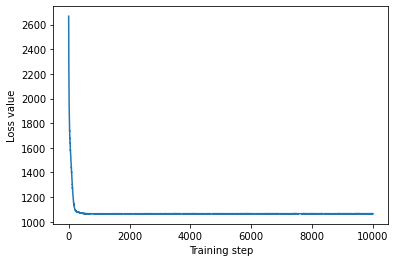

In [12]:
optimizer = tf.optimizers.Adam(learning_rate=1e-2)
@tf.function(jit_compile=True)
def fit_vi():
  return tfp.vi.fit_surrogate_posterior(
      target_model.unnormalized_log_prob,
      surrogate_posterior,
      optimizer=optimizer,
      num_steps=10**4,
      sample_size=16,
      )
mvn_loss = fit_vi()

mvn_samples = surrogate_posterior.sample(1000)
mvn_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*mvn_samples)

    - surrogate_posterior.log_prob(mvn_samples))

print('Multivariate Normal surrogate posterior ELBO: {}'.format(mvn_final_elbo))

plt.plot(mvn_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')